# This program is created by ...

In [2]:
# Import all the necessary packages:
import numpy as np                     # type: ignore
import matplotlib.pyplot as plt        # type: ignore
from datasets import load_dataset      # type: ignore
import cv2                             # type: ignore

%matplotlib inline

## Download the dataset. This will probably take 4-7 minutes

#### Download straight from HuggingFace, then convert the training data into a pandas DataFrame

In [3]:
# Download the dataset
ds = load_dataset("marmal88/skin_cancer")

In [ ]:
df = ds["train"].to_pandas()

#### Render an image

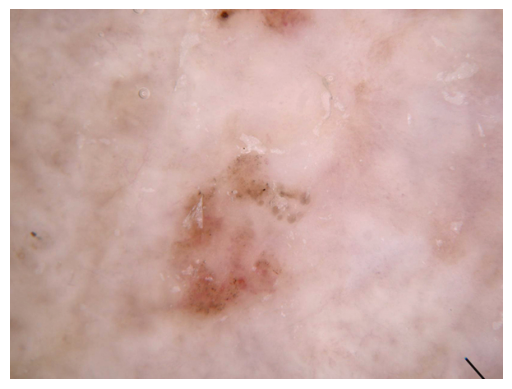

In [ ]:
image_bytes = df.iloc[0]["image"]["bytes"]

# Convert the byte data into a NumPy array
nparr = np.frombuffer(image_bytes, np.uint8)

# Decode the image array into an image using OpenCV
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

# Convert the image from BGR (OpenCV's default) to RGB for correct display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide axis
plt.show()

## Implement the Sobel and Canny edge detectors that we will use across the training dataset

#### Sobel

In [7]:
def ApplySobel(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobelx, sobely)
    return cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

#### Canny

In [8]:
def ApplyCanny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.Canny(gray, 100, 200)

## Now, apply Sobel and Canny to each image in the training set

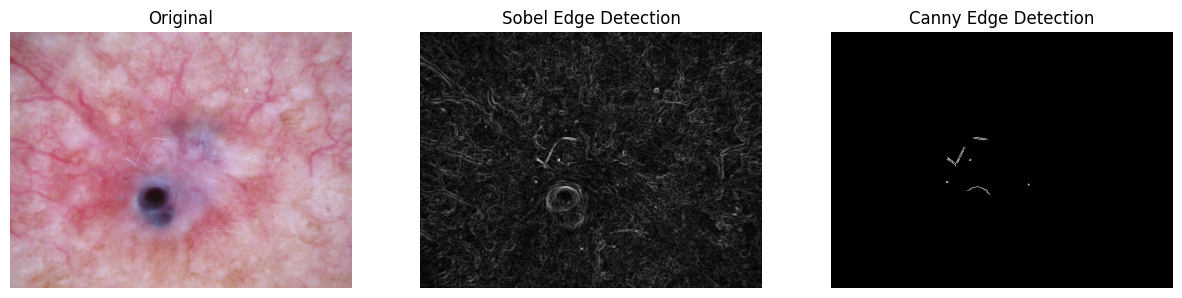

In [9]:
sobelImages = []
cannyImages = []

for index, row in df.iterrows():
    image_bytes = row["image"]["bytes"]
    nparr = np.frombuffer(image_bytes, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    sobel_image = ApplySobel(image_rgb)
    canny_image = ApplyCanny(image_rgb)
    
    sobelImages.append(sobel_image)
    cannyImages.append(canny_image)

# Display sample images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_rgb)
axes[0].set_title("Original")
axes[1].imshow(sobel_image, cmap='gray')
axes[1].set_title("Sobel Edge Detection")
axes[2].imshow(canny_image, cmap='gray')
axes[2].set_title("Canny Edge Detection")
for ax in axes:
    ax.axis("off")
plt.show()

# Hello